# 为了提升性能，我们还能怎么做？

上节课我们讲了，训练准确率接近100%，而验证准确率在70%-80%。这是因为“过拟合”。

过拟合也可以理解为：模型在训练集表现良好，在测试集表现不佳。

过拟合原因有：
1. 训练数据少（数据增强）
2. 模型参数多（dropout）

那我们如何缓解过拟合呢？

## 上节课的数据增强的方法

In [ ]:
%load_ext tensorboard
import os
import pathlib

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[0:4], device_type="GPU")


path_to_file = tf.keras.utils.get_file(
    "cats_and_dogs_filtered.zip",
    cache_subdir="cats_and_dogs_filtered",
    origin="http://aimaksen.bslience.cn/cats_and_dogs_filtered.zip",
    extract=True,
)

train_dir = pathlib.Path(path_to_file).parent / "cats_and_dogs_filtered/train"
validation_dir = pathlib.Path(path_to_file).parent / "cats_and_dogs_filtered/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 归一化
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode="binary", target_size=(224, 224)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode="binary", target_size=(224, 224)
)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

model = tf.keras.models.Sequential(
    [
        data_augmentation,
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


from datetime import datetime

# Define the Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "-augumentation-wired"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_steps=50,
    verbose=1,
    callbacks=[tensorboard_callback],
)

In [ ]:
%tensorboard --logdir logs --port=6123 --bind_all

## 另一种数据增强的操作方法
数据增强：让有限的数据产生更多的等价数据。

举几个例子：\
比如：一张猫的照片，水平翻转或垂直翻转都是猫的图片。\
比如：一张猫的图片随机选取图像的一部分，然后将其缩放到原图像尺度，依旧是猫的图片。\
比如：一张猫的图片修改其色调，依旧是一张猫的图片。

我们可以根据上述举例，使用 API 对原有数据集进行数据增强。

我们来看看 ImageGenerator。它有一些属性可以用来进行数据增强。
```
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```

* rotation_range：图片随机转动的角度。
* width_shift：图片水平偏移的幅度
* height_shift：图片竖直偏移的幅度
* shear_range：用于随机剪切变换。
* zoom_range：用于随机缩放图片。
* horizontal_flip：用于随机水平翻转。
* fill_mode：填充新创建像素的策略，可用于旋转或宽度/高度偏移后出现。

我们添加了有关图像增强的代码，运行它来查看效果。

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 22s 216ms/step - loss: 0.6914 - accuracy: 0.5385 - val_loss: 0.6663 - val_accuracy: 0.6320
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.6688 - accuracy: 0.5940 - val_loss: 0.6205 - val_accuracy: 0.6600
Epoch 3/100
100/100 [==============================] - 21s 206ms/step - loss: 0.6370 - accuracy: 0.6320 - val_loss: 0.5969 - val_accuracy: 0.6950
Epoch 4/100
100/100 [==============================] - 21s 209ms/step - loss: 0.6283 - accuracy: 0.6495 - val_loss: 0.5849 - val_accuracy: 0.6930
Epoch 5/100
100/100 [==============================] - 21s 207ms/step - loss: 0.6099 - accuracy: 0.6615 - val_loss: 0.5877 - val_accuracy: 0.6920
Epoch 6/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6053 - accuracy: 0.6660 - val_loss: 0.5520 - val_accuracy: 0.7190
Epoch 7/100
100/100 [===================

In [14]:
%tensorboard --logdir logs --port=6123 --bind_all

Reusing TensorBoard on port 6123 (pid 104002), started 0:42:46 ago. (Use '!kill 104002' to kill it.)

## 还能怎么提高？


![](image/thinking.jpeg)


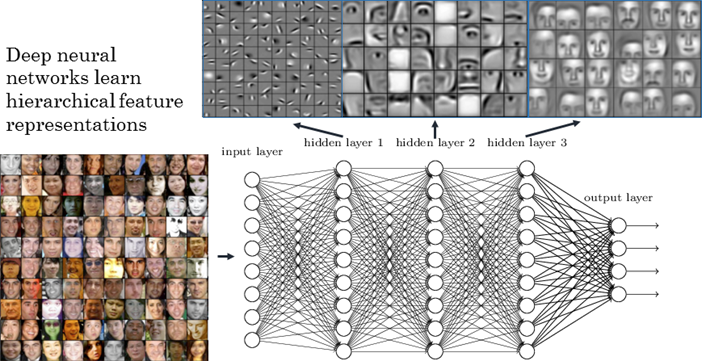## 迁移学习

### 什么是迁移学习

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)


一个形象的比喻

![](https://miro.medium.com/max/882/1*TIMA09tVqZe7tA6DckoP6g.png)


我们之前训练的模型

![](https://miro.medium.com/max/1400/1*BBZGHtI_vhDBeqsIbgMj1w.png)



下载文件：http://aimaksen.bslience.cn/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

我们知道过拟合是如何产生的，我们也采用了数据增广方式来避免过拟合。但这样的方式缺点就在于我们都要构建模型重头开始训练。


是否有可能存在一个已经训练好的模型，并将其学习得到的特征应用到我们所需要预测的样本上呢？这就是迁移学习主要干的事。我们将已训练模型所得到的参数给锁定，直接将这些训练好的特征投入到需要进行下一步训练的模型当中。


inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 是已经训练好的模型，将其迁移到 cats_and_dogs_filtered 数据集中，帮助提高训练准确率。


[预训练模型接口地址](https://www.tensorflow.org/api_docs/python/tf/keras/applications/)

In [ ]:
from tensorflow.keras import Model, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()



In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer

In [7]:
last_layer.output_shape

(None, 12, 12, 768)

In [8]:
last_output = last_layer.output
last_output.shape

TensorShape([None, 12, 12, 768])

In [12]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
______________________________________________________________________________________________

In [15]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics='accuracy')

In [16]:
len(model.trainable_variables)

4

In [ ]:
%tensorboard --logdir logs --port=6123 --bind_all

## Finetune 更多层的参数

Number of layers in the pretrained model:  311


84

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 27s 237ms/step - loss: 0.3376 - accuracy: 0.8790 - val_loss: 0.1518 - val_accuracy: 0.9720
Epoch 2/10
100/100 [==============================] - 22s 215ms/step - loss: 0.1377 - accuracy: 0.9555 - val_loss: 0.1007 - val_accuracy: 0.9770
Epoch 3/10
100/100 [==============================] - 22s 216ms/step - loss: 0.0866 - accuracy: 0.9710 - val_loss: 0.0746 - val_accuracy: 0.9850
Epoch 4/10
100/100 [==============================] - 22s 218ms/step - loss: 0.0751 - accuracy: 0.9755 - val_loss: 0.1413 - val_accuracy: 0.9780
Epoch 5/10
100/100 [==============================] - 22s 216ms/step - loss: 0.0828 - accuracy: 0.9735 - val_loss: 0.1297 - val_accuracy: 0.9820
Epoch 6/10
100/100 [==============================] - 22s 220ms/step - loss: 0.0613 - accuracy: 0.9795 - val_loss: 0.1103 - val_accuracy: 0.9790
Epoch 7/10
100/100 [==========================

In [27]:
%tensorboard --logdir logs --port=6123 --bind_all